<div style="font-size: 32px; color: gray; font-weight: bold; text-align: center;">ARIMA to predict price</div>

---

## Libraries

In [1]:
# !pip install pmdarima

In [2]:
# Libraries
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import pandas as pd
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as tckr
import matplotlib.dates as mdates
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import boto3
from io import StringIO
from sagemaker import get_execution_role

In [29]:
# print(plt.style.available)

In [4]:
plt.style.use("seaborn")

## Parameters

In [5]:
test_ticker = "MC.PA"
test_startdate = "2020-01-01"
test_enddate = "2021-12-31"
train_size = .8

## Get data

### Prices & Volumes

In [6]:
# Read data from s3
role = get_execution_role()
bucket="euronext-stocks"
data_key = "data.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df_data = pd.read_csv(data_location, header=[0, 1],)
df_data.set_index(df_data["Unnamed: 0_level_0"]["Unnamed: 0_level_1"], drop=True, inplace=True)
df_data.index.name = "Date"
df_data.drop("Unnamed: 0_level_0", axis=1, inplace=True)
df_data.drop(df_data.index[0], inplace=True)
df_data.index = pd.to_datetime(df_data.index)
df_data.interpolate(method='linear', inplace=True) # use linear interpolation for missing values

In [7]:
# df_data.shape

In [8]:
# df_data.head(3)

### Adj Close Prices

In [9]:
df_adjclose = df_data["Adj Close"]

In [10]:
df_adjclose.shape

(514, 706)

In [11]:
df_adjclose.head(3)

,2CRSI.PA,2MX.PA,AAA.PA,AALB.AS,AB.PA,ABCA.PA,ABEO.PA,ABI.BR,ABIO.PA,ABN.AS,...,WKL.AS,WLN.PA,XFAB.PA,XIL.PA,XIOR.BR,XPO.PA,YATRA.AS,ZENT.BR,^FCHI,^N100
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-23,9.04,NaN,1.315385,28.260750,4.335,5.543856,28.962732,67.888748,18.910824,16.294355,...,59.963905,50.099998,4.750,35.700001,40.271324,273.466217,3.36,16.299999,5281.370117,1031.750000
2019-05-24,9.02,NaN,1.315385,28.326471,4.220,5.570255,28.468489,67.732155,19.072538,16.497494,...,60.311073,51.500000,4.895,36.250000,40.544350,273.466217,3.36,16.400000,5316.509766,1037.339966
2019-05-27,9.10,NaN,1.315385,28.495472,4.200,5.631852,27.974243,68.432228,19.453037,16.648767,...,60.330360,51.500000,4.810,35.650002,40.726368,273.466217,3.36,16.500000,5336.189941,1041.579956


µ = 416.8351026008101
1 std (68.27%) = +/-82.17296499490672
2 std (95.45%) = +/-164.34592998981344
3 std (99.73%) = +/-246.51889498472016


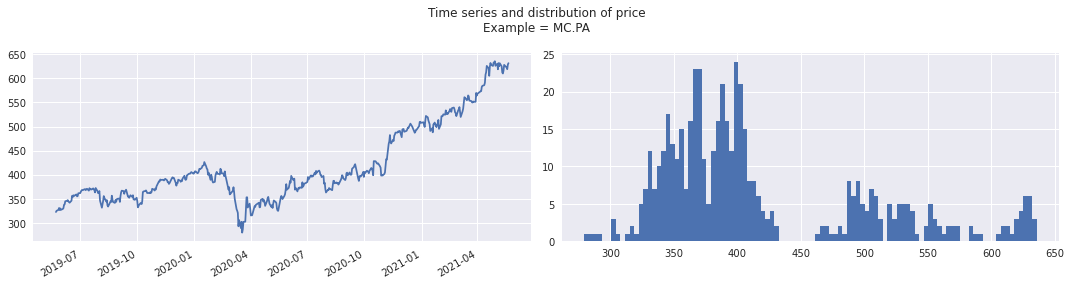

In [12]:
# Example plots showing characteristics of price
fig = plt.figure(figsize=(15,4))

plt.suptitle(f"Time series and distribution of price\nExample = {test_ticker}")

ax1 = fig.add_subplot(121)
df_adjclose[test_ticker].plot(ax=ax1)
ax1.set_xlabel(None)
# plt.grid() # turn off when using seaborn style

ax2 = fig.add_subplot(122)
df_adjclose[test_ticker].hist(bins=100, ax=ax2)

mean = df_adjclose[test_ticker].mean()
std = df_adjclose[test_ticker].std()

print(f"µ = {mean}")
print(f"1 std (68.27%) = +/-{std}")
print(f"2 std (95.45%) = +/-{2*std}")
print(f"3 std (99.73%) = +/-{3*std}")

plt.tight_layout()

## EDA

### Define target time series

In [13]:
y = df_adjclose[test_startdate:test_enddate][test_ticker]

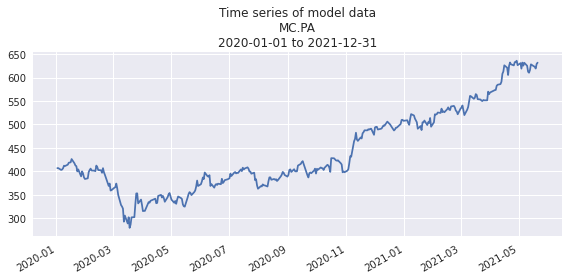

In [17]:
y.plot(figsize=(8,4))
plt.xlabel(None)
plt.title(f"Time series of model data\n{test_ticker}\n{test_startdate} to {test_enddate}")
plt.tight_layout()

In [237]:
# Plot sparklines for an arbitrary period (*** TEST ***)
# freq = "M"
# groups = y.groupby(Grouper(freq=freq))

# fig = plt.figure(figsize=(6,3))
# fig.patch.set_visible(False)
# ax.axis('off')

# df_periods = pd.DataFrame()
# i = 1
# for name, group in groups:
# #     print(name.month)
# #     print(group.values)
#     df_periods[f"Period_{i}"] = group.values[:15]
#     i += 1

# num_subplots = len(df_periods.columns)
# figheight = int(num_subplots*.7)

# fig = plt.figure(figsize=(6,figheight))
# fig.patch.set_visible(False)

# for i in range(1, num_subplots+1):
#     ax = fig.add_subplot(num_subplots, 1, i)
#     df_periods.iloc[:, i-1].plot(ax=ax)
#     ax.axis('off')
# plt.suptitle(f"Sparklines to look for periodic trends\n(Frequency={freq})")
# plt.tight_layout()

### Distribution of price

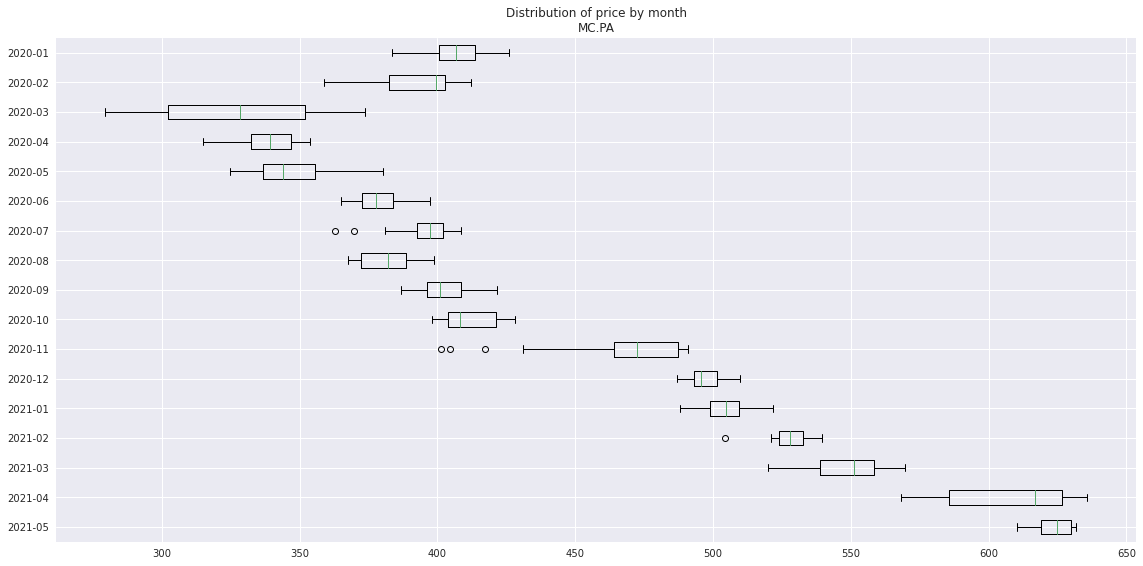

In [19]:
# Boxplots of prices by month
boxplot_data = y.reset_index()
boxplot_data["Year_Month"] = boxplot_data["Date"].apply(lambda x: x.strftime("%Y-%m"))

periods = list(boxplot_data["Year_Month"].unique())


data = []
for period in periods:
    plotdata = boxplot_data.loc[boxplot_data["Year_Month"] == period][test_ticker]
    data.append(plotdata)
data = data[::-1]
periods = periods[::-1]

fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, vert=False)

ax.set_yticklabels(periods)

# plt.axvline(x=0, color="darkblue", linestyle="--")

plt.title(f"Distribution of price by month\n{test_ticker}")
plt.tight_layout()

### Lag analysis & auto-correlation

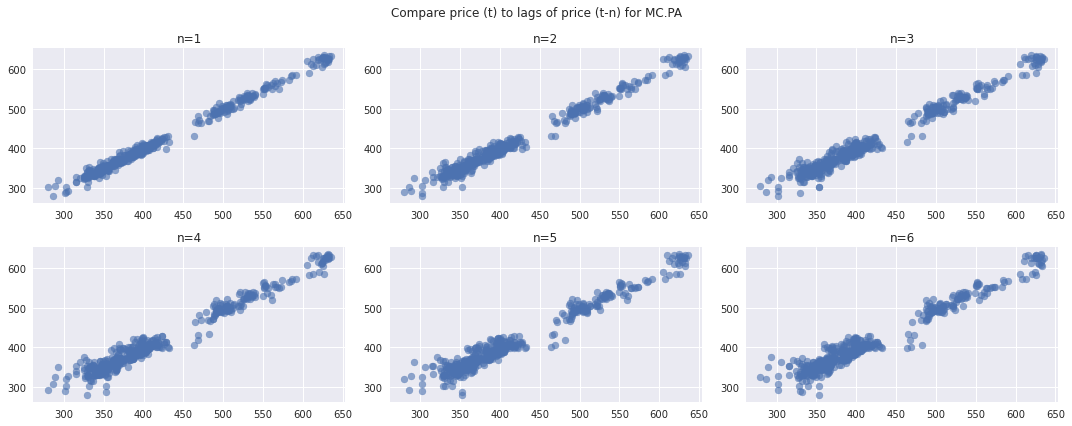

In [20]:
# Compare lags of prices
lags = range(1,7)

fig = plt.figure(figsize=(15,6))
for lag in lags:
    ax = fig.add_subplot(2, 3, lag)
    plt.scatter(x=df_adjclose[test_ticker], y=df_adjclose[test_ticker].shift(periods=lag), alpha=.6)
    ax.set_title(f"n={lag}")
#     plt.grid() # turn off when using seaborn style
plt.suptitle(f"Compare price (t) to lags of price (t-n) for {test_ticker}")
plt.tight_layout()

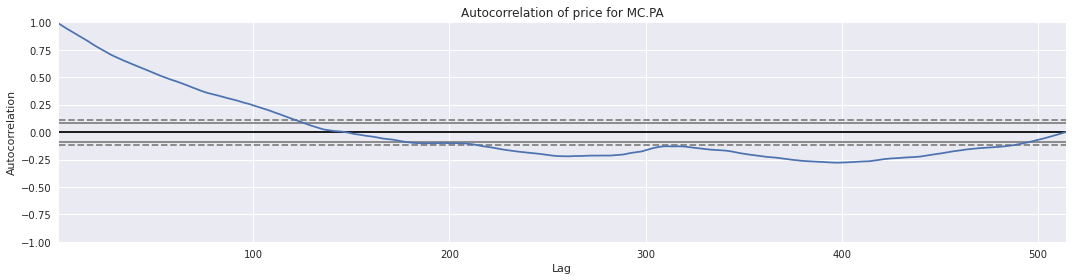

In [21]:
# Autocorrelation plot
fig = plt.figure(figsize=(15,4))
ax = autocorrelation_plot(df_adjclose[test_ticker])
plt.grid()
plt.title(f"Autocorrelation of price for {test_ticker}")
plt.tight_layout()

## ARIMA model

### Train / Test split

In [22]:
# Train / Test split
train_idx = int(y.shape[0] * train_size)
y_train = y.iloc[:train_idx]
y_test = y.iloc[train_idx:]
print(y_train.shape)
print(y_test.shape)

(284,)
(72,)


### Estimate d

In [23]:
# Run KPSS and ADF tests
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
print(f"kpss d estimate: {kpss_diffs}")
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
print(f"adf d estimate: {adf_diffs}")
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

kpss d estimate: 1
adf d estimate: 1
Estimated differencing term: 1


### Fit model

In [24]:
# Use auto_arima to find best pdq parameters
auto = pm.auto_arima(
    y_train,
    d=n_diffs, # discovered from KPSS / ADF tests
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_P=6,
    max_order=None,
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2008.270, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2005.773, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2007.001, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2007.153, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2004.481, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2007.233, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.419 seconds


In [25]:
# Show parameters discovered by auto_arima
print(auto.order)

(0, 1, 0)


### Make forecast and update the model

In [26]:
model = auto

In [27]:
# Generate forecasts and calculate MSE and SMAPE
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 58.161112556492725
SMAPE: 1.0514339314559318


### Visualize forecasts

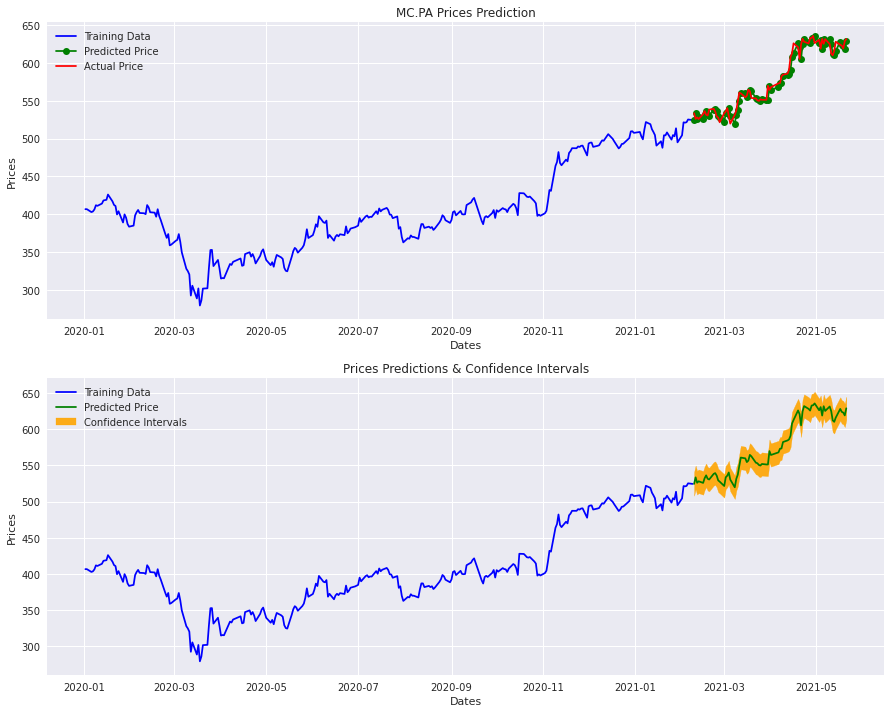

In [28]:
# Plot Actual vs Forecast and Predicted with Confidence Levels

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
# axes[0].plot(test_data.index, forecasts, color='green', marker='o',
#              label='Predicted Price')
axes[0].plot(y_test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

# axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].plot(y_test.index, y_test, color='red', label='Actual Price')
axes[0].set_title(f'{test_ticker} Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(y_test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(y_test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()